# 2. Quantizing embeddings

In [2]:
import os
import time
import torch
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, fbeta_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import random
import pickle
import sys
from torch.profiler import profile, ProfilerActivity
from torch.ao.quantization.observer import MinMaxObserver
# !pip install qnet

sys.path.insert(0, os.path.abspath('../'))

from calflops import calculate_flops

In [4]:
from qnet import *

In [3]:
class Args:
    # data_path = './efficientnet_b3_1536_bs64'
    # data_path = './efficientnet_b3_1536_bs64_PCA0.95'
    data_path = '/home/sebastian/codes/repo_clean/VE_paper/0_VE_extraction/E_NET_EMBEDDINGS/urban8k_efficientnet_b3/efficientnet_b3_1536_bs64'
    output_dir = 'output'
    total_num_seed = 1
    num_classes = 5
    num_epochs = 5
    batch_size = 64
    learning_rate = 1e-3
    model = 'mlp'
    device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'
    pca = False
    variance_threshold = 0.8

args = Args()

# Fix paths to use current working directory
device = torch.device(args.device)
print(f"Using device: {device}")

Using device: cpu


SEED 0
--------------------------------
structure of data is:  (7488, 1536) (7488,)
structure of data is:  (836, 1536) (836,)
Reset trainable parameters of layer = Linear(in_features=1536, out_features=256, bias=True)
Reset trainable parameters of layer = LayerNorm((256,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=128, bias=True)
Reset trainable parameters of layer = LayerNorm((128,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=64, bias=True)
Reset trainable parameters of layer = LayerNorm((64,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=5, bias=True)
Epoch 1/5, F1 Score: 0.7584885970830594


[W129 05:16:47.568344460 CPUAllocator.cpp:249] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event


total_cpu_memory_train (MB):  1267.7296829223633
total_cpu_memory_inference (MB):  30.271072387695312
total_cpu_memory (MB):  1298.0007553100586
Training time: 0.61 seconds
Inference time: 0.03 seconds
{'EMB_size_out': 1536, 'Accuracy': 0.7583732057416268, 'F1 Score': 0.7584885970830594, 'F0.75 Score': 0.7588240630886479, 'Precision': 0.7603134286414138, 'Recall': 0.7583732057416268, 'Training time': 0.6055309772491455, 'Inference time': 0.02823925018310547, 'Mem. Train (MB)': 1267.7296829223633, 'Mem. Infer (MB)': 30.271072387695312, 'Total. RAM': 1298.0007553100586}
Model saved in: /home/sebastian/codes/repo_clean/VE_paper/1_Classification/output/mlp_efficientnet_b3_1536_bs64_data_quantized/seed_0/mlp_efficientnet_b3_1536_bs64_data_quantized_0.pkl
Consolidated metrics saved at /home/sebastian/codes/repo_clean/VE_paper/1_Classification/output/mlp_efficientnet_b3_1536_bs64_data_quantized/consolidated_metrics_mlp.csv
Average and variance metrics saved at /home/sebastian/codes/repo_clean

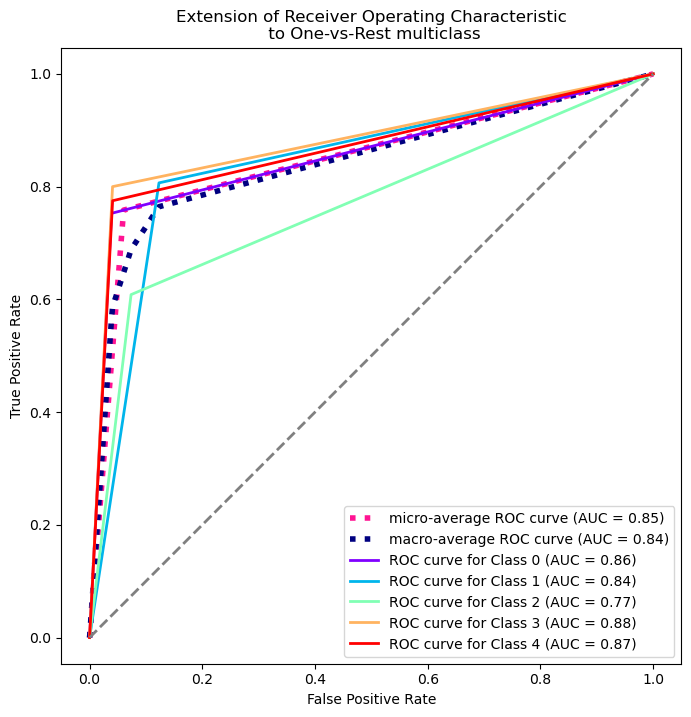

In [8]:
quantized_data = True

for seed in range(args.total_num_seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    print(f'SEED {seed}')
    print('--------------------------------')
    
    train_csv = os.path.join(args.data_path, 'train_embeddings.csv')
    val_csv = os.path.join(args.data_path, 'val_embeddings.csv')
    
    experiment_folder = f"{args.model}_{args.data_path.split('/')[-1]}"
    if quantized_data:
        experiment_folder += "_data_quantized"
    output_folder = os.path.join(os.getcwd(), args.output_dir, experiment_folder)
    seed_dir = os.path.join(output_folder, f"seed_{seed}")
    quantized_dir = os.path.join(output_folder, f"experiment_folder_quantizedVE")

    os.makedirs(quantized_dir, exist_ok=True)

    os.makedirs(seed_dir, exist_ok=True)

    # Load datasets with quantization and proper typing
    train_dataset = QuantizedEmbeddingDataset(train_csv, save_dir=quantized_dir, train=True, save_embeddings=False)
    val_dataset = QuantizedEmbeddingDataset(val_csv, save_dir=quantized_dir, train=False, save_embeddings=False)

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)

    class_counts = np.bincount(np.asarray(train_dataset.labels, int))
    class_weights = 1.0 / class_counts
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    num_columns = train_dataset[0][0].shape[0]
    
    model = SClassifier(num_columns, args.num_classes, hidden_sizes=[256, 128, 64]).to(device)
    model.apply(reset_weights)

    # Train Model with Profiler
    with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof_train:
        start_train_time = time.time()
        model_trained, train_losses, val_losses = train_pytorch(args, model, train_loader, val_loader, class_weights, num_columns, device,seed_dir)
        end_train_time = time.time()

    # Get total CPU memory usage during training
    total_cpu_memory_train = sum(event.cpu_memory_usage for event in prof_train.key_averages())/(1024 * 1024)
    # print(prof_train.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

    # Eval. Model with Profiler
    with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof_eval:
        start_inference_time = time.time()
        all_labels, all_preds = eval_pytorch_model(model_trained, val_loader, device)
        end_inference_time = time.time()

    # Get total CPU memory usage during inference
    total_cpu_memory_inference = sum(event.cpu_memory_usage for event in prof_eval.key_averages())/(1024 * 1024)
    # print(prof_eval.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

    training_time = end_train_time - start_train_time
    inference_time = end_inference_time - start_inference_time

    # Update memory with the sum of training and inference memory usage
    print("total_cpu_memory_train (MB): ", total_cpu_memory_train)
    print("total_cpu_memory_inference (MB): ", total_cpu_memory_inference)

    metrics = get_all_metrics(num_columns, all_labels, all_preds, total_cpu_memory_train, total_cpu_memory_inference, training_time, inference_time)  # Convert to MB

    print(f'Training time: {training_time:.2f} seconds')
    print(f'Inference time: {inference_time:.2f} seconds')
    print(metrics)
    
    save_predictions(seed_dir, experiment_folder, model, metrics, all_labels, all_preds, seed)
    plot_multiclass_roc_curve(all_labels, all_preds, seed_dir)
    y_train = train_dataset.labels
    save_confusion_matrix(all_labels, all_preds, np.unique(y_train), seed_dir, "val")

consolidate_and_average_metrics(args, output_folder)
print("Evaluation across different seeds completed. Results saved to the output directory.")

SEED 0
--------------------------------
Reset trainable parameters of layer = Linear(in_features=1536, out_features=256, bias=True)
Reset trainable parameters of layer = LayerNorm((256,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=128, bias=True)
Reset trainable parameters of layer = LayerNorm((128,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=64, bias=True)
Reset trainable parameters of layer = LayerNorm((64,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=5, bias=True)
Epoch 1/5, F1 Score: 0.7382104233862928
Epoch 2/5, F1 Score: 0.6061617592084527
Epoch 3/5, F1 Score: 0.7826097733334111
Epoch 4/5, F1 Score: 0.8019819162117717
Epoch 5/5, F1 Score: 0.7985854699916078

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of pa

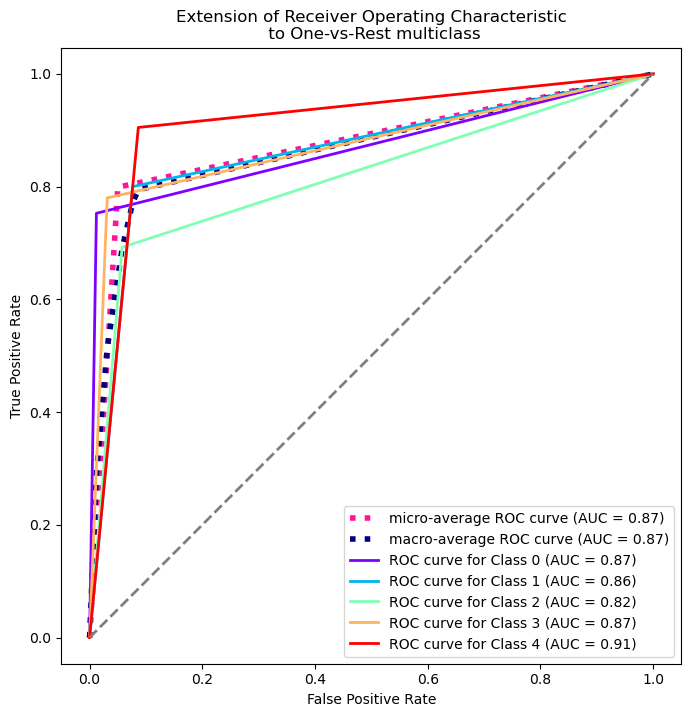

In [3]:
# quantized_data = True

# for seed in range(args.total_num_seed):
#     torch.manual_seed(seed)
#     np.random.seed(seed)
#     print(f'SEED {seed}')
#     print('--------------------------------')
    
#     train_csv = os.path.join(args.data_path, 'train_embeddings.csv')
#     val_csv = os.path.join(args.data_path, 'val_embeddings.csv')
    
#     experiment_folder = f"{args.model}_{args.data_path.split('/')[-1]}"
#     if quantized_data:
#         experiment_folder += "_data_quantized"
#     output_folder = os.path.join(os.getcwd(), args.output_dir, experiment_folder)
#     seed_dir = os.path.join(output_folder, f"seed_{seed}")
#     quantized_dir = os.path.join(output_folder, f"experiment_folder_quantizedVE")

#     os.makedirs(quantized_dir, exist_ok=True)

#     os.makedirs(seed_dir, exist_ok=True)

#     # Load datasets with quantization and proper typing
#     train_dataset = QuantizedEmbeddingDataset(train_csv, save_dir=quantized_dir, train=True, save_embeddings=False)
#     val_dataset = QuantizedEmbeddingDataset(val_csv, save_dir=quantized_dir, train=False, save_embeddings=False)

#     train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)

#     class_counts = np.bincount(np.asarray(train_dataset.labels, int))
#     class_weights = 1.0 / class_counts
#     class_weights = torch.tensor(class_weights, dtype=torch.float32)
    
#     patience = 50  
#     best_f1 = 0.0
#     patience_counter = 0
    
#     if args.model == 'mlp':
#         torch.manual_seed(seed)
#         np.random.seed(seed)
#         class_weights = class_weights.to(device)
        
        
#         model = SClassifier(train_dataset[0][0].shape[0] , args.num_classes, 
#                           hidden_sizes=[256, 128, 64]).to(device)
#         model.apply(reset_weights)
        
#         optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
#         criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
#         scheduler = ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.8)

#         train_losses = []
#         val_losses = []
#         start_train_time = time.time()

#         for epoch in range(args.num_epochs):
#             model.train()
#             epoch_train_loss = 0
            
#             for inputs, labels in train_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 optimizer.zero_grad()
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()
#                 epoch_train_loss += loss.item() * inputs.size(0)
            
#             # Validation
#             model.eval()
#             epoch_train_loss /= len(train_loader.dataset)
#             train_losses.append(epoch_train_loss)
            
#             epoch_val_loss = 0
#             all_labels, all_preds = [], []
            
#             with torch.inference_mode():
#                 for inputs, labels in val_loader:
#                     inputs, labels = inputs.to(device), labels.to(device)
#                     outputs = model(inputs)
#                     loss = criterion(outputs, labels)
#                     epoch_val_loss += loss.item() * inputs.size(0)
#                     _, predicted = torch.max(outputs.data, 1)
#                     all_labels.extend(labels.cpu().numpy())
#                     all_preds.extend(predicted.cpu().numpy())
            
#             epoch_val_loss /= len(val_loader.dataset)
#             val_losses.append(epoch_val_loss)

#             f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
#             print(f'Epoch {epoch+1}/{args.num_epochs}, F1 Score: {f1}')
#             scheduler.step(f1)
            
#             if f1 > best_f1:
#                 best_f1 = f1
#                 patience_counter = 0
#                 torch.save(model.state_dict(), os.path.join(seed_dir, 'best_model.pth'))
#             else:
#                 patience_counter += 1

#             if patience_counter >= patience:
#                 print("Early stopping triggered")
#                 break

#         # Final evaluation
#         model_memory = get_memory_usage()
#         start_inference_time = time.time()
        
#         all_labels, all_preds = [], []
#         with torch.inference_mode():
#             for inputs, labels in val_loader:
#                 inputs = inputs.to(device)
#                 outputs = model(inputs)
#                 _, predicted = torch.max(outputs.data, 1)
#                 all_labels.extend(labels.cpu().numpy())
#                 all_preds.extend(predicted.cpu().numpy())
        
#         training_time = time.time() - start_train_time
#         inference_time = time.time() - start_inference_time
#         plot_losses(train_losses, val_losses, seed_dir)

#     # Metrics calculation and saving
#     accuracy = accuracy_score(all_labels, all_preds)
#     f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
#     precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
#     recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
#     f1_075 = fbeta_score(all_labels, all_preds, beta=0.75, average='weighted', zero_division=0)
    
#     flops, macs, params = calculate_flops(model=model, 
#                                       input_shape=(1, train_dataset.features.shape[1]), 
#                                       output_as_string=False,
#                                       output_precision=4)
#     metrics = {
#         'EMB_size_out': train_dataset[0][0].shape[0],
#         'Accuracy': accuracy,
#         'F1 Score': f1,
#         'F0.75 Score': f1_075,
#         'Precision': precision,
#         'Recall': recall,
#         'Training time': training_time,
#         'Inference time': inference_time,
#         'Memory RAM': model_memory,
#         'KFLOPS':flops/1e3,
#         'KMACS':macs/1e3,
#         'KPARAMS':params/1e3
#     }
#     print(metrics)
    
#     save_predictions(seed_dir, experiment_folder, model, metrics, all_labels, all_preds, seed)
#     plot_multiclass_roc_curve(all_labels, all_preds, seed_dir)
#     save_confusion_matrix(all_labels, all_preds, np.unique(train_dataset.labels), seed_dir, "val")

# consolidate_and_average_metrics(args, output_folder)
# print("Evaluation completed. Results saved to:", output_folder)

In [10]:
import torch
from calflops import calculate_flops
input_shape = (1, train_dataset.features.shape[1])  # Assuming X_train is defined and has the correct shape

dummy_input = torch.randn(input_shape).to(device)  # Random tensor with the appropriate shape

original_model = SClassifier(train_dataset.features.shape[1], args.num_classes, hidden_sizes=[256, 128, 64]).to(device)

# we load the best model
# delete = "/home/sebastian/codes/repo_clean/VE_paper/1_Classification/results_jan_28/mlp_efficientnet_b3_1536_bs64_quantized_model/seed_0"
model_path = os.path.join(seed_dir, "best_model.pth")
print(model_path)
# model_path = os.path.join(delete, "best_model.pth")
original_model.load_state_dict(torch.load(model_path, map_location=device,weights_only=True))

original_model.eval()

for param in original_model.parameters():
    param.requires_grad_(False)

quantized_model = torch.quantization.quantize_dynamic(
    original_model,
    {torch.nn.Linear},
    dtype=torch.qint8
)
flops, macs, params = calculate_flops(model=original_model, 
                                      input_shape=input_shape,
                                      output_as_string=False,
                                      output_precision=4)

results = {'KFLOPS':flops/1e3,
            'KMACS':macs/1e3,
            'KPARAMS':params/1e3}
print(results)

/home/sebastian/codes/repo_clean/VE_paper/1_Classification/output/mlp_efficientnet_b3_1536_bs64_data_quantized/seed_0/best_model.pth

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  0       
fwd MACs:                                                               434.496 KMACs
fwd FLOPs:                                                              871.685 KFLOPS
fwd+bwd MACs:                                                           1.3035 MMACs
fwd+bwd FLOPs:                                                 

871.685 KFLOPS